In [3]:
%load_ext autoreload
%autoreload 2

import torch 
import os
import glob
from matplotlib import pyplot as plt

import matplotlib.animation as animation
import os
import torch
import numpy as np
import pandas as pd
from functools import partial
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')


from distributions import ZeroInflatedDist, QuantizedNormal
from torch_models import MixtureOfTruncNormModel, SpatialWaves
from torch_training import train_epoch
from torch_perturb.torch_pert_topk import PerturbedBrokenTopK
from torch_perturb.perturbations import perturbed
import time
from torch_training import train_epoch_largesynth, train_epoch_largesynth_loo
from torch_models import torch_bpr_uncurried, deterministic_bpr
from metrics import top_k_onehot_indicator

2024-09-16 16:20:47.550535: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 16:20:47.595666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 16:20:47.595703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 16:20:47.596782: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 16:20:47.604472: I tensorflow/core/platform/cpu_feature_guar

In [18]:
data_dir='/cluster/home/kheuto01/code/prob_diff_topk'

step_size=0.1
perturbed_noise=0.0001
K=100
threshold=1
rows=27
cols=60
data_shape=(rows, cols)
deaths = pd.read_csv(os.path.join(data_dir,'deaths_band.csv'))
pop = pd.read_csv(os.path.join(data_dir, 'pop_band.csv'))
num_score_samples = 50
num_pert_samples = 50
bpr_weight=30
nll_weight=0

# turn the death column into a time-by-geoid array
deaths_TS = deaths.pivot(index='time', columns='geoid', values='death').values
pop_S = pop['pop'].values

T, S = deaths_TS.shape
# create latitude and longitude arrays corresponding to the row and column index of the geoids when reshaped into data_shape
lat = np.linspace(-rows/2, rows/2, rows)
lon = np.linspace(-cols/2, cols/2, cols)
lat_S, lon_S = np.meshgrid(lon, lat)
lat_S = lat_S.flatten()
lon_S = lon_S.flatten()
# create column of time values
time_T = np.arange(deaths_TS.shape[0])
time_T = torch.tensor(time_T, dtype=torch.float32)
lat_S = torch.tensor(lat_S, dtype=torch.float32)
lon_S = torch.tensor(lon_S, dtype=torch.float32)
pop_S = torch.tensor(pop_S, dtype=torch.float32)
deaths_TS = torch.tensor(deaths_TS, dtype=torch.float32)
S = pop_S.shape[0]
T = time_T.shape[0]


model  = SpatialWaves(num_waves=1,low=0, high=1000000)

optimizer = torch.optim.Adam(model.parameters(), lr=step_size)

M_score_func =  num_score_samples
M_action = M_score_func

top_k_func = partial(top_k_onehot_indicator, k=K)
perturbed_top_K_func = perturbed(top_k_func, sigma=perturbed_noise, num_samples=num_pert_samples)#PerturbedBrokenTopK(k=K, sigma=perturbed_noise, num_samples=num_pert_samples)#

In [19]:
good_exp = '/cluster/tufts/hugheslab/kheuto01/large_synth_band_4000/bw0_nw1_ss0.1_nss100_nps100'
model = SpatialWaves(num_waves=1, low=0, high=100000)
model.load_state_dict(torch.load(good_exp + '/model.pth'))

<All keys matched successfully>

In [6]:
arrival_speeds, arrival_intercepts, lat_coeff, lon_coeff, softplusinv_magnitudes, softplusinv_peak_widths = model.single_tensor_to_params(model.params_to_single_tensor())

In [27]:

grads= []
score_grads = []
det_bprs, pert_bprs, nlls = [], [], []
for softinv_peak_width in np.linspace(softplusinv_peak_widths.detach().numpy()*0.5, softplusinv_peak_widths.detach().numpy()*1.5, 20):
    print(softinv_peak_width)
    model = SpatialWaves(num_waves=1, low=0, high=100000)
    model.load_state_dict(torch.load(good_exp + '/model.pth'))
    model.update_params(torch.cat([arrival_speeds, arrival_intercepts, lat_coeff, lon_coeff, softplusinv_magnitudes, torch.tensor(softinv_peak_width).reshape(1)]))

    grad, score_grad, det_bpr, pert_bpr, nll = get_grads(model, K, threshold, T,
                                        M_score_func, M_action,time_T,pop_S,
                                        lat_S, lon_S, deaths_TS, 
                                        perturbed_top_K_func, bpr_weight, 
                                        nll_weight)
    grads.append(grad)
    score_grads.append(score_grad)
    det_bprs.append(det_bpr)
    pert_bprs.append(pert_bpr)
    nlls.append(nll)

[0.44006485]


/tmp/ipykernel_61322/527308191.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
/tmp/ipykernel_61322/527308191.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))
/tmp/ipykernel_61322/527308191.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)


[0.48638746]
[0.5327101]
[0.57903266]
[0.6253553]
[0.67167795]
[0.71800053]
[0.7643231]
[0.81064576]
[0.8569684]
[0.903291]
[0.94961363]
[0.9959362]
[1.0422587]
[1.0885814]
[1.1349041]
[1.1812267]
[1.2275493]
[1.2738719]
[1.3201945]


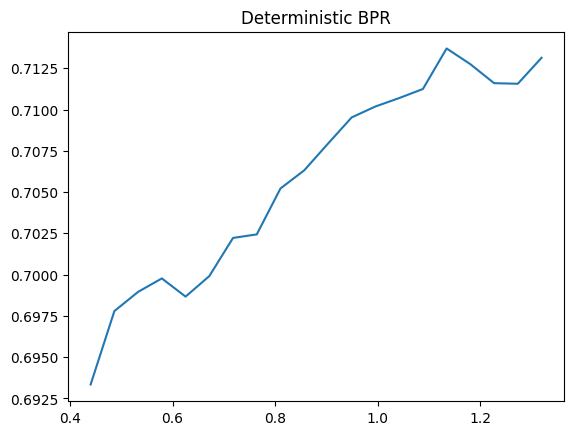

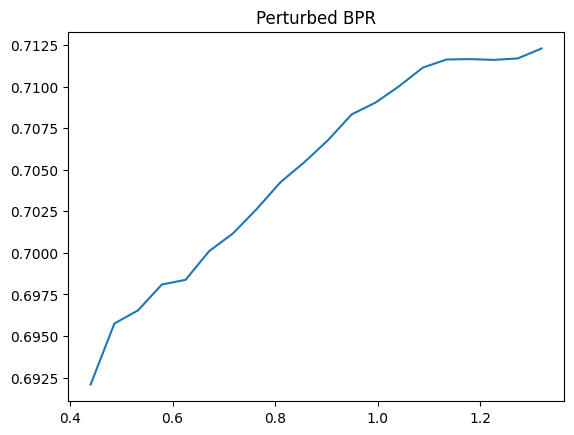

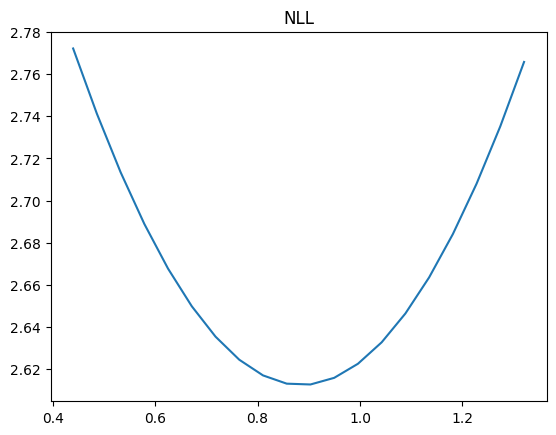

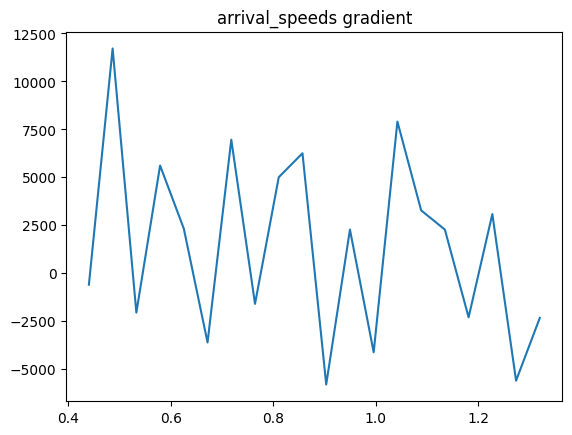

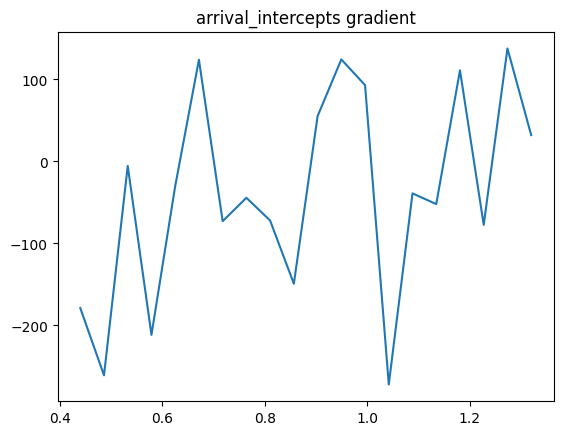

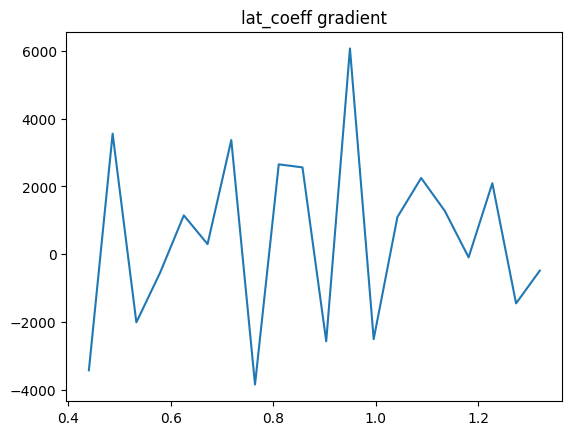

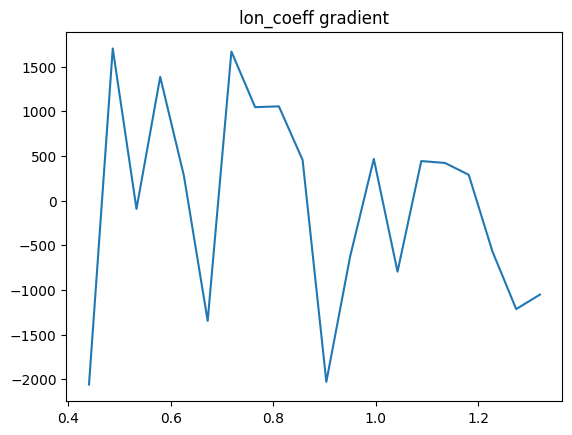

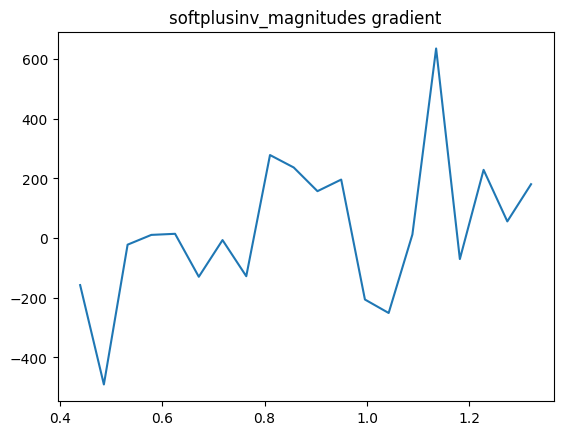

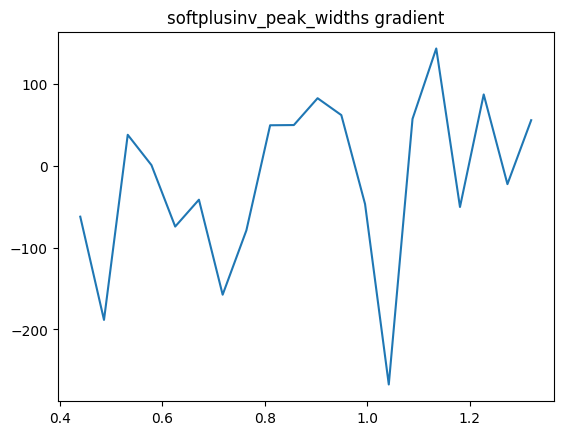

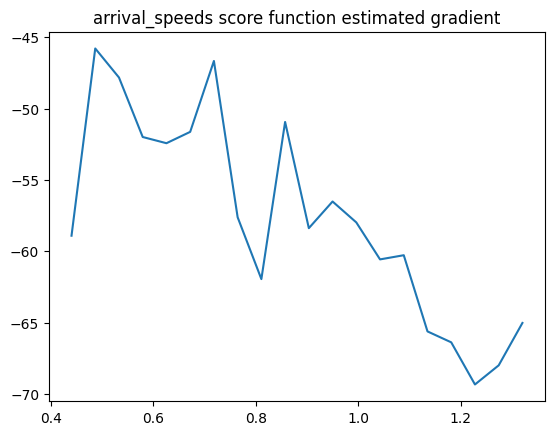

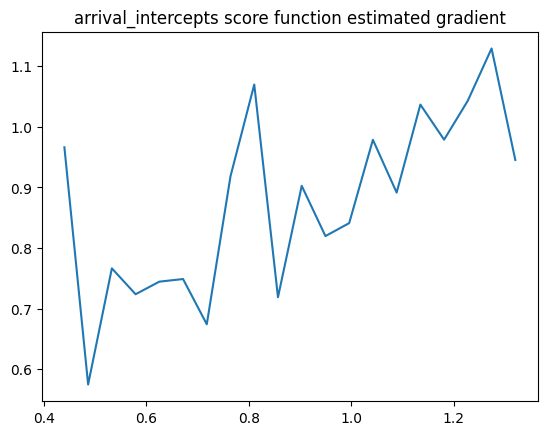

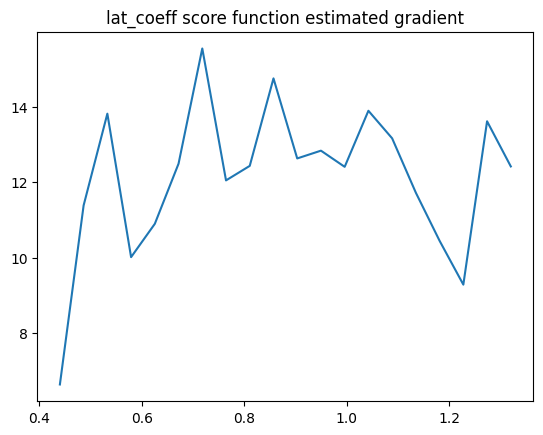

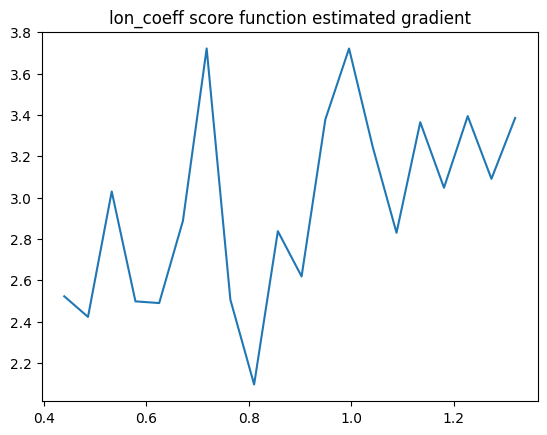

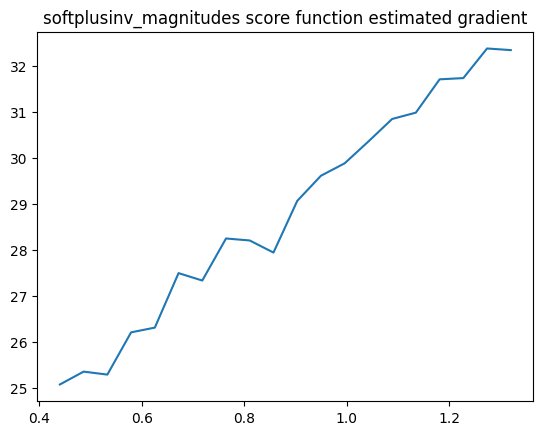

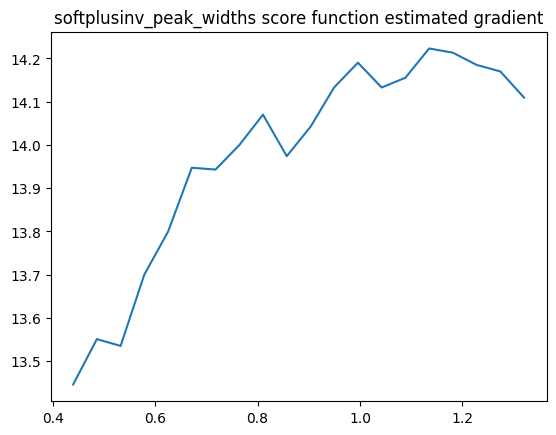

In [29]:
plt.plot(np.linspace(softplusinv_peak_widths.detach().numpy()*0.5, softplusinv_peak_widths.detach().numpy()*1.5, 20), det_bprs)
plt.title('Deterministic BPR')
plt.show()
plt.plot(np.linspace(softplusinv_peak_widths.detach().numpy()*0.5, softplusinv_peak_widths.detach().numpy()*1.5, 20), [bpr.detach() for bpr in pert_bprs])
plt.title('Perturbed BPR')
plt.show()
plt.plot(np.linspace(softplusinv_peak_widths.detach().numpy()*0.5, softplusinv_peak_widths.detach().numpy()*1.5, 20), [nll.detach() for nll in nlls])
plt.title('NLL')
plt.show()

for g, name in enumerate(['arrival_speeds', 'arrival_intercepts', 'lat_coeff', 'lon_coeff', 'softplusinv_magnitudes', 'softplusinv_peak_widths']):
    plt.plot(np.linspace(softplusinv_peak_widths.detach().numpy()*0.5, softplusinv_peak_widths.detach().numpy()*1.5, 20), [grad[g].detach() for grad in grads])
    plt.title(name+' gradient')
    plt.show()

for g, name in enumerate(['arrival_speeds', 'arrival_intercepts', 'lat_coeff', 'lon_coeff', 'softplusinv_magnitudes', 'softplusinv_peak_widths']):
    plt.plot(np.linspace(softplusinv_peak_widths.detach().numpy()*0.5, softplusinv_peak_widths.detach().numpy()*1.5, 20), [grad[g].detach() for grad in score_grads])
    plt.title(name+' score function estimated gradient')
    plt.show()

In [57]:
    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)

tensor(0.0080)


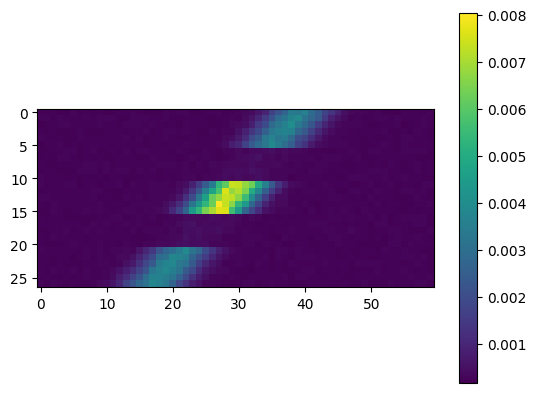

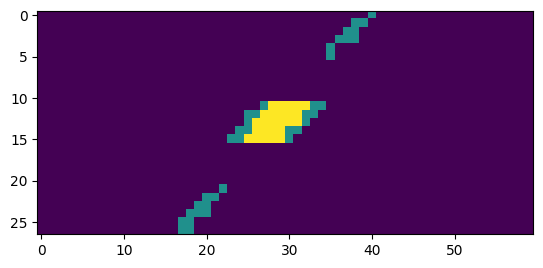

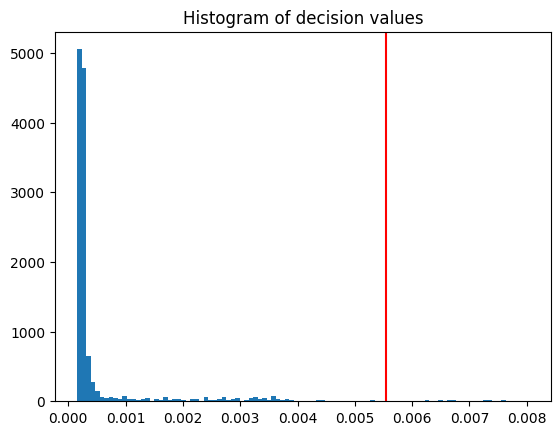

In [58]:
plt.imshow(ratio_rating_TS[25].view(27,60))
plt.colorbar()
print(ratio_rating_TS[25].max())
plt.show()
# plot image of mask of highest 25 values
plt.imshow((ratio_rating_TS[25]+0.002>=ratio_rating_TS[25].topk(25).values.min()).view(27,60)*1.0+1.0*(ratio_rating_TS[25]>=ratio_rating_TS[25].topk(25).values.min()).view(27,60))
#plt.imshow((ratio_rating_TS[25]+0.002>=ratio_rating_TS[25].topk(25).values.min()).view(27,60))
plt.show()
# make histogram and highlight largest 25 values
plt.hist(ratio_rating_TS[25].flatten().detach().numpy(), density=True, bins=100)
plt.title('Histogram of decision values')
plt.axvline(ratio_rating_TS[25].flatten().topk(25).values.min(), color='red')
plt.show()

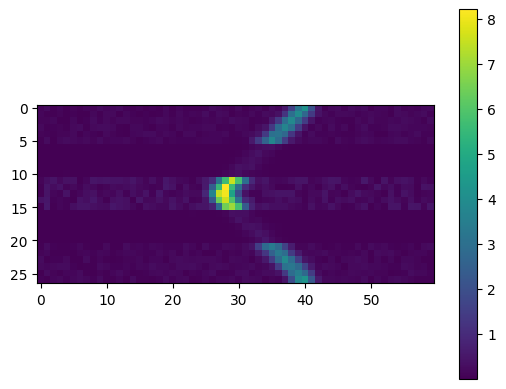

In [7]:
plt.imshow(deaths_TS[25].view(27,60))
plt.colorbar()

In [8]:
def get_grads(model, K, threshold, T,
                           M_score_func, M_action,
                           time_T,pop_S, lat_S, lon_S, train_y_TS,
                           perturbed_top_K_func, bpr_weight, nll_weight, ):

    optimizer.zero_grad()
    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)

    def get_log_probs_baked(param):
        distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
        log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

        return log_probs_TMS
    
    jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)

    all_sample_tot = ratio_rating_TMS.sum(dim=-2, keepdim=True)
    all_other_sample_mean = (all_sample_tot-ratio_rating_TMS)/(T-1)
    score_func_estimator_TMSP = jac_TMSP * (ratio_rating_TMS - all_other_sample_mean).unsqueeze(-1)
    score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    


    #score_func_estimator_TMSP = jac_TMSP * ratio_rating_TMS.unsqueeze(-1)
    #score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)    

    # get gradient of negative bpr_t  with respect to ratio rating_TS

    positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)
    if nll_weight>0:
        bpr_threshold_diff_T = positive_bpr_T - threshold
        violate_threshold_flag = bpr_threshold_diff_T < 0
        negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
    else:
        negative_bpr_loss = torch.mean(-positive_bpr_T)
    
    nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

    loss = bpr_weight*negative_bpr_loss + nll_weight*nll
    loss.backward()
    loss_grad_TS = ratio_rating_TS.grad

    score_func_grad_P = torch.sum(score_func_estimator_TSP, dim=[0,1]).detach()
 
    gradient_TSP = score_func_estimator_TSP * torch.unsqueeze(loss_grad_TS, -1)
    gradient_P = torch.sum(gradient_TSP, dim=[0,1])

    gradient_tuple = model.single_tensor_to_params(gradient_P)

    for param, gradient in zip(model.parameters(), gradient_tuple):
        if nll_weight>0:
            gradient = gradient + param.grad
        param.grad = gradient

    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    det_bpr =torch.mean(deterministic_bpr_T)

    return [param.grad for param in model.parameters()], [param for param in score_func_grad_P], det_bpr,  positive_bpr_T.mean(), nll

In [9]:
def calc_nll_bpr(model, K, M_score_func,
                 time_T,pop_S, lat_S, lon_S, train_y_TS,
                 perturbed_top_K_func):

    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)
 

    positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)

    
    nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))


    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    det_bpr =torch.mean(deterministic_bpr_T)


    return  det_bpr.detach(), nll.detach(), model

In [43]:
bpr, nll, model = calc_nll_bpr(model, K,
                                M_score_func, time_T,pop_S,
                                lat_S, lon_S, deaths_TS, 
                                perturbed_top_K_func, )
print(f'BPR: {bpr}, NLL: {nll}')

/tmp/ipykernel_232266/611565847.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)


BPR: 0.7885093688964844, NLL: 3.875850200653076


/tmp/ipykernel_232266/611565847.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))
/tmp/ipykernel_232266/611565847.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)


In [4]:
init_vec = model.params_to_single_tensor().detach().numpy()

In [6]:
init_vec[2]=-init_vec[2]
init_vec[3]=-init_vec[3]

In [7]:
model.update_params(torch.tensor(init_vec, dtype=torch.float32))

In [20]:
losses, bprs, nlls, times = [], [], [], []
for epoch in range(100):
    print(f'EPOCH: {epoch}')
    start = time.time()
    loss, bpr, nll, model = halfweay(model, optimizer, K, threshold, T,
                                        M_score_func, M_action,time_T,pop_S,
                                        lat_S, lon_S, deaths_TS, 
                                        perturbed_top_K_func, bpr_weight, 
                                        nll_weight)

EPOCH: 0
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])


/tmp/ipykernel_74249/1314093725.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)


det bpr: 0.7071493268013
Pert bpr: 0.7064317464828491
nll: 2.6123809814453125
Loss: -21.19295310974121


/tmp/ipykernel_74249/1314093725.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))
/tmp/ipykernel_74249/1314093725.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)


EPOCH: 1
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.7077544927597046
Pert bpr: 0.7065215110778809
nll: 2.6123809814453125
Loss: -21.19564437866211
EPOCH: 2
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.709051787853241
Pert bpr: 0.7067438364028931
nll: 2.6123809814453125
Loss: -21.202314376831055
EPOCH: 3
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.708092987537384
Pert bpr: 0.7069213390350342
nll: 2.6123809814453125
Loss: -21.207639694213867
EPOCH: 4
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.7075427174568176
Pert bpr: 0.7064306735992432
nll: 2.6123809814453125
Loss: -21.192920684814453
EPOCH: 5
train_y_TS size: torch.Size([64, 1620])
ratio_rating_TS size: torch.Size([64, 1620])
det bpr: 0.7094330787658691
Pert bpr: 0.7064846754074097
nll: 2.6123809814453125
Loss: -21.19454002380371

In [16]:

def halfweay(model, optimizer, K, threshold, T,
                           M_score_func, M_action,
                           time_T,pop_S, lat_S, lon_S, train_y_TS,
                           perturbed_top_K_func, bpr_weight, nll_weight, update=True):

    optimizer.zero_grad()
    dist = model(time_T,pop_S, lat_S, lon_S)
    
    y_sample_TMS = dist.sample((M_score_func,)).permute(1, 0, 2)
    y_sample_action_TMS = y_sample_TMS

    ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
    ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
    ratio_rating_TS.requires_grad_(True)

    def get_log_probs_baked(param):
        distribution = model.build_from_single_tensor(param, time_T, pop_S, lat_S, lon_S)
        log_probs_TMS = distribution.log_prob(y_sample_TMS.permute(1, 0, 2)).permute(1, 0, 2)

        return log_probs_TMS
    
    jac_TMSP = torch.autograd.functional.jacobian(get_log_probs_baked, (model.params_to_single_tensor()), strategy='forward-mode', vectorize=True)

     

    # get gradient of negative bpr_t  with respect to ratio rating_TS
    print(f'train_y_TS size: {train_y_TS.shape}')
    print(f'ratio_rating_TS size: {ratio_rating_TS.shape}')
    positive_bpr_T = torch_bpr_uncurried(ratio_rating_TS, torch.tensor(train_y_TS), K=K, perturbed_top_K_func=perturbed_top_K_func)

    score_func_estimator_TMSP = jac_TMSP * -positive_bpr_T.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    score_func_estimator_TSP = score_func_estimator_TMSP.mean(dim=1)   


    if nll_weight>0:
        bpr_threshold_diff_T = positive_bpr_T - threshold
        violate_threshold_flag = bpr_threshold_diff_T < 0
        negative_bpr_loss = torch.mean(-bpr_threshold_diff_T*violate_threshold_flag)
    else:[]
        negative_bpr_loss = torch.mean(-positive_bpr_T)
    
    nll = torch.mean(-dist.log_prob( torch.tensor(train_y_TS)))

    loss = bpr_weight*negative_bpr_loss + nll_weight*nll
    #loss.backward()
    loss_grad_TS = ratio_rating_TS.grad

    gradient_TSP = score_func_estimator_TSP #* torch.unsqueeze(loss_grad_TS, -1)
    gradient_P = torch.sum(gradient_TSP, dim=[0,1])

    gradient_tuple = model.single_tensor_to_params(gradient_P)

    for param, gradient in zip(model.parameters(), gradient_tuple):
        if nll_weight>0:
            gradient = gradient + param.grad
        param.grad = gradient
    if update:
        optimizer.step()

    deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(train_y_TS), K=K)
    det_bpr =torch.mean(deterministic_bpr_T)

    print(f'det bpr: {det_bpr}')
    print(f'Pert bpr: {torch.mean(positive_bpr_T)}')
    print(f'nll: {nll}')
    print(f'Loss: {loss}')
    sys.stdout.flush()

    return loss.detach(), det_bpr.detach(), nll.detach(), model